# <font color='purple'> Simplified Regression Analysis for ships

## Importing dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Reading and manipulating the file

In [2]:
path = r'C:\Users\Cris\Documents\Projects\Similar_vessels.xlsx' # Database path
df = pd.read_excel(path) # Reading the excel file

df.rename(columns = {'LOA (m)': 'L [m]', 'Beam (m)': 'B [m]', 'Depth (m)': 'D [m]', 'Economical Speed (kts)': 'V_s [kts]', 
                     'Deck Cargo Area (m2)': 'A_deck [m2]', 'Design Draft (m)': 'T_d [m]', 'Summer Draft (m)': 'T_max [m]', 
                     'Deadweight (ton)': 'DWT [t]'}, inplace=True) # Renaming the columns

df.dropna(subset=['D [m]'], axis=0, inplace=True) # Droping every row that contains no value for the depth column
df.reset_index(drop=True, inplace=True) # Reseting the index

In [3]:
L = df['L [m]'] # Length of the vessels
T1 = df['T_d [m]'] # Designed drafts of the vessels
T2 = df['T_max [m]'] # Maximum draft of the vessels
D = df['D [m]'] # Depth of the vessels

df.loc[(L <= 65) & (T1.isnull()), 'T_d [m]'] = min(T1) # inserting the minimum value of the design draft into the null rows of the same column for smaller ships
df.loc[(L >= 90) & (T1.isnull()), 'T_d [m]'] = max(T1) # inserting the maximum value of the design draft into the null rows of the same column for bigger ships
df.loc[(L > 65) & (L <= 75) & (T1.isnull()), 'T_d [m]'] = round(T1.mean() - T1.std(), 3) # Inserting intermediary values for medium sized ships
df.loc[(L > 75) & (L < 90) & (T1.isnull()), 'T_d [m]'] = round(T1.mean(), 3)

In [4]:
# Obtaining the relationship between some parameters

df['L/B'] = round(df['L [m]'] / df['B [m]'], 2)
df['B/T_d'] = round(df['B [m]'] / df['T_d [m]'], 2)
df['D/T_d'] = round(df['D [m]'] / df['T_d [m]'], 2)

df['T_m/T_d'] = round(df['T_max [m]'] / df['T_d [m]'], 2)
df['A/LB'] = round(df['A_deck [m2]'] / (df['L [m]'] * df['B [m]']), 3)

## Visualizing the initial rows of the table

In [5]:
df.head(10)

,Vessel,Type,L [m],B [m],D [m],Max Speed (kts),V_s [kts],A_deck [m2],T_d [m],T_max [m],DWT [t],L/B,B/T_d,D/T_d,T_m/T_d,A/LB
0,POSH CONSTANT,AHTS,74.50,17.2,8.0,12.0,10.0,500.0,5.500,6.817,2564.0,4.33,3.13,1.45,1.24,0.390
1,POSH COMANDER,AHTS,75.27,18.0,8.1,12.0,10.0,516.0,6.000,6.600,3186.0,4.18,3.00,1.35,1.10,0.381
2,POSH RAPTOR,AHTS,70.33,16.6,7.2,13.5,10.0,475.0,4.500,5.900,2350.0,4.24,3.69,1.60,1.31,0.407
3,POSH DARING,AHTS,81.00,16.8,7.5,12.0,10.0,650.0,6.250,6.250,3083.0,4.82,2.69,1.20,1.00,0.478
4,BOURBON ARCTIC,AHTS,93.60,24.0,9.8,16.0,8.0,780.0,7.160,7.800,4129.0,3.90,3.35,1.37,1.09,0.347
5,BOURBON ARGOS,AHTS,68.60,15.4,7.0,14.0,10.0,420.0,5.629,6.000,2100.0,4.45,2.74,1.24,1.07,0.398
6,BAHTERA TEGUH,AHTS,64.80,16.0,5.8,14.0,9.0,420.0,4.300,4.900,1611.0,4.05,3.72,1.35,1.14,0.405
7,BOURBON LIBERTY,AHTS,59.78,15.0,5.5,13.5,10.0,331.0,4.300,4.880,1460.0,3.99,3.49,1.28,1.13,0.369
8,BOURBON ALEXANDRE,AHTS,67.00,15.4,7.0,14.0,9.0,420.0,5.629,5.950,2100.0,4.35,2.74,1.24,1.06,0.407
9,BOURBON SURF,AHTS,87.70,18.0,8.0,18.0,12.0,500.0,6.000,6.600,3117.0,4.87,3.00,1.33,1.10,0.317


## Obtaining the linear regression equations and plotting them for some of the ship parameters

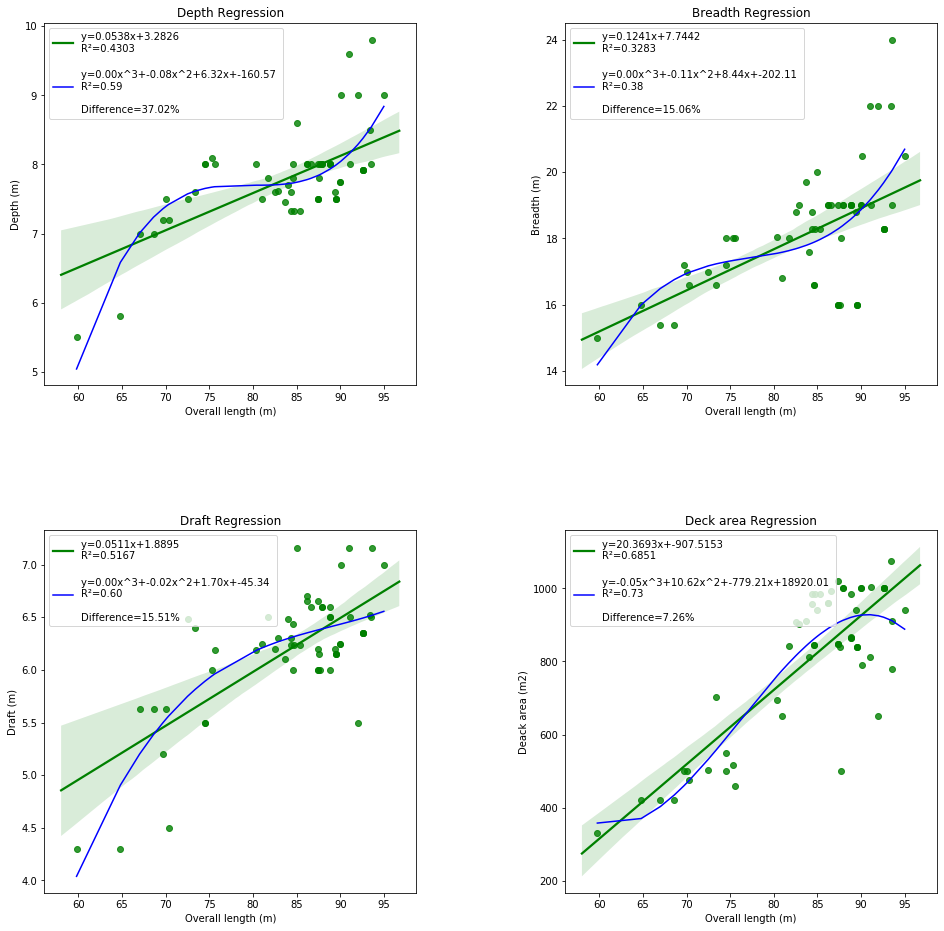

In [18]:
x = L.values # LOA values
y0 = D.values # Depth values
y1 = df['B [m]'].values # Breadth values
y2 = T1.values # Molded draft values
y3 = df['A_deck [m2]'].values # Deck area values
y = [y0, y1, y2, y3] # Creating a list for the compared parameters

Titles = ['Depth Regression', 'Breadth Regression', 'Draft Regression', 'Deck area Regression']
Y_labels = ['Depth (m)', 'Breadth (m)', 'Draft (m)', 'Deack area (m2)'] # List of y labels
fig = plt.figure(figsize=(16, 16)) # Creating the figure
fig.subplots_adjust(hspace=0.4, wspace=0.4) # Adjusting the spaces between the subplots 

for i in range(4): # Loop for iterating between the subplots
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y[i]) # Obtaining important parameters based on a linear regression
    plt.subplot(2, 2, i + 1) # Creating the first subplot
    sns.regplot(x, y[i], color='g', line_kws={'label':"y={0:.4f}x+{1:.4f} \nR²={2:.4f}".format(slope,intercept,r_value**2)})
    
    fit = np.polyfit(x, y[i], 3) # Obtaining a polynomial regression with third order
    r_squared = r2_score(y[i], np.polyval(fit, x)) # Getting the r_squared value
    Diff = abs(r_value**2 - r_squared) / r_value**2 * 100 # Calculating the increase percentage for the r_squared between the different regressions
    plt.plot(np.sort(x), np.polyval(fit,np.sort(x)), color='b',label=("\ny={0:.2f}x^3+{1:.2f}x^2+{2:.2f}x+"+
             "{3:.2f} \nR²={4:.2f} \n\nDifference={5:.2f}%").format(fit[0],fit[1],fit[2],fit[3],r_squared,Diff))
    plt.title(Titles[i])
    plt.xlabel('Overall length (m)')
    plt.ylabel(Y_labels[i])
    plt.legend(loc='upper left')
    


## <font color='red'> As shown in the graphs, is not simple to find the right regression to fit that type of data, that is why in many simplified cases, the increase in R squared by changing the regression from first order to third order or higher, is neglected during the first approach for a similar vessel analysis, meaning that usually a simple linear regression is the one used!